### Preparation
Dataset Preparation

In [1]:
import pandas as pd
import geopandas as gpd
import warnings

# Load dataset
df = pd.read_csv('data/wilkerstat/masking_infrastructutre.csv', sep='~')
df['provinsi'] = df.DESA2020_2.apply(lambda r: int(str(r)[:2]))
print(df.shape)
df.head()

(1948424, 7)


,latitude,longitude,accuracy,DESA2020_2,jenis_infra,nama,provinsi
0,-4.729118,122.726172,3.0,7402081006,TK Negeri,infra desa ke-1,74
1,-4.729056,122.726136,3.0,7402081006,SD Negeri,infra desa ke-2,74
2,-4.733765,122.726644,3.0,7402081006,SMK Swasta,infra desa ke-3,74
3,-4.728721,122.725981,3.0,7402081006,Puskesmas tanpa rawat inap,infra desa ke-4,74
4,-4.731726,122.727547,3.0,7402081006,Tempat praktek bidan,infra desa ke-5,74


In [2]:
# Filter POI wilkerstat for Java island
df = df.loc[(df.provinsi > 30) & (df.provinsi < 40)]
df = df.reset_index(drop=True)
print(df.shape)
df.provinsi.value_counts()

(1031336, 7)


35    336563
32    293457
33    270234
36     52072
34     45229
31     33781
Name: provinsi, dtype: int64

In [7]:
# for i in sorted(df.jenis_infra.unique()):
#     print(i)

# Warung:
# Warung/kedai makanan minuman
# Warung Jamu/Toko herbal/Toko Obat

# Supermarket:
# Supermarket

# Pasar:
# Pasar dengan bangunan permanen
# Pasar dengan bangunan semi permanen
# Pasar tanpa bangunan

# Kelompok Pertokoan:
# Kelompok pertokoan

# Mall:
# Mall

# Minimarket:
# Minimarket

In [8]:
# Category of infrastructure/POI required
poi = {
        'warung' :['Warung/kedai makanan minuman', 'Warung Jamu/Toko herbal/Toko Obat'],
        'supermarket' :['Supermarket'],
        'pasar':['Pasar dengan bangunan permanen', 'Pasar dengan bangunan semi permanen', 'Pasar tanpa bangunan'],
        'klp_toko':['Kelompok pertokoan'],
        'mall' :['Mall'],
        'minimarket':['Minimarket']
    }

def get_kat(i):
    for key, value in poi.items():
        res = None
        if i in value:
            res = key
            break
    return res

In [9]:
# Filter only the appropriate POI categories
df['kat_infra'] = df.jenis_infra.apply(get_kat)
df = df[df.kat_infra.notnull()]
print(df.shape)
df.provinsi.value_counts()

(367916, 8)


35    149807
33     89020
32     78828
36     17943
34     17785
31     14533
Name: provinsi, dtype: int64

<AxesSubplot:title={'center':'Kategori Infrastruktur (Jawa)'}, ylabel='kat_infra'>

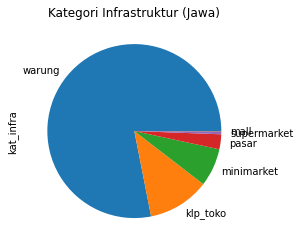

In [11]:
# Show
df['kat_infra'].value_counts().plot(kind='pie', title='Kategori Infrastruktur (Jawa)')

Convert to Geo-DataFrame and save the output

In [12]:
# Convert to geo-dataframe
dfg = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_xy(df.longitude, df.latitude), crs=4326)
print(dfg.crs)
dfg.head()

epsg:4326


,latitude,longitude,accuracy,DESA2020_2,jenis_infra,nama,provinsi,kat_infra,geometry
7,-8.091890,111.939082,2.4,3504100011,Warung/kedai makanan minuman,infra desa ke-8,35,warung,POINT (111.93908 -8.09189)
8,-8.092022,111.939092,2.2,3504100011,Warung/kedai makanan minuman,infra desa ke-9,35,warung,POINT (111.93909 -8.09202)
9,-8.094377,111.939337,2.2,3504100011,Warung/kedai makanan minuman,infra desa ke-10,35,warung,POINT (111.93934 -8.09438)
10,-8.096866,111.939811,1.7,3504100011,Warung/kedai makanan minuman,infra desa ke-11,35,warung,POINT (111.93981 -8.09687)
11,-8.093868,111.939447,1.5,3504100011,Warung/kedai makanan minuman,infra desa ke-12,35,warung,POINT (111.93945 -8.09387)


<AxesSubplot:>

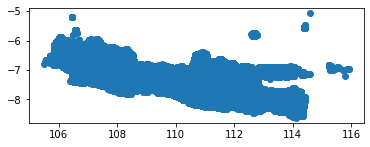

In [13]:
# Show
dfg.plot()

In [14]:
# Save the output into a file
dfg.to_file('data/wilkerstat/extract/wilkerstat-java-poi-ekonomi.shp')

/tmp/ipykernel_94447/1544757924.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dfg.to_file('data/wilkerstat/extract/wilkerstat-java-poi-ekonomi.shp')


### Preprocessing
Load shp for each province

In [15]:
import glob
import numpy as np
from tqdm import tqdm

shp_list = glob.glob('data/grid/one_poly/*/*.shp')
shp_list

['data/grid/one_poly/shp_grid_31_one/shp_grid_31_one.shp',
 'data/grid/one_poly/shp_grid_32_one/shp_grid_32_one.shp',
 'data/grid/one_poly/shp_grid_33_one/shp_grid_33_one.shp',
 'data/grid/one_poly/shp_grid_34_one/shp_grid_34_one.shp',
 'data/grid/one_poly/shp_grid_35_one/shp_grid_35_one.shp',
 'data/grid/one_poly/shp_grid_36_one/shp_grid_36_one.shp']

Create a buffer for each province with a distance of +/-5KM

In [16]:
def set_buffer(f):
    # read file
    kode = f.replace('_one','').split('.')[0][-2:]
    shp  = gpd.read_file(f).iloc[:,-5:]
    shp  = shp.to_crs(4326)
    shp['geometry'] = shp['geometry'].buffer(0.044999, cap_style=3, join_style=2) #5km
    
    # within poi wikerstat dengan buffer provinsi
    dfg[kode] = dfg.within(shp.loc[0, 'geometry'])

warnings.filterwarnings('ignore')
for f in tqdm(shp_list):
    set_buffer(f)
dfg.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:32<00:00, 25.35s/it]


,latitude,longitude,accuracy,DESA2020_2,jenis_infra,nama,provinsi,kat_infra,geometry,31,32,33,34,35,36
7,-8.091890,111.939082,2.4,3504100011,Warung/kedai makanan minuman,infra desa ke-8,35,warung,POINT (111.93908 -8.09189),False,False,False,False,True,False
8,-8.092022,111.939092,2.2,3504100011,Warung/kedai makanan minuman,infra desa ke-9,35,warung,POINT (111.93909 -8.09202),False,False,False,False,True,False
9,-8.094377,111.939337,2.2,3504100011,Warung/kedai makanan minuman,infra desa ke-10,35,warung,POINT (111.93934 -8.09438),False,False,False,False,True,False
10,-8.096866,111.939811,1.7,3504100011,Warung/kedai makanan minuman,infra desa ke-11,35,warung,POINT (111.93981 -8.09687),False,False,False,False,True,False
11,-8.093868,111.939447,1.5,3504100011,Warung/kedai makanan minuman,infra desa ke-12,35,warung,POINT (111.93945 -8.09387),False,False,False,False,True,False


Save dataset POI-buffer

In [17]:
dfg.to_file('data/wilkerstat/buffer/wikerstat-java-poi-buffer-ekonomi.shp')

Exploration

In [18]:
for kode in np.sort(dfg.provinsi.unique()):
    print(f'PROVINSI-{kode}')
    print(dfg.loc[dfg[str(kode)]==True].provinsi.value_counts())

PROVINSI-31
31    14533
32     8317
36     3258
Name: provinsi, dtype: int64
PROVINSI-32
32    78828
31     3440
36     1906
33      634
Name: provinsi, dtype: int64
PROVINSI-33
33    89020
34     2993
35     2736
32     1570
Name: provinsi, dtype: int64
PROVINSI-34
34    17785
33     2127
Name: provinsi, dtype: int64
PROVINSI-35
35    149807
33      2021
Name: provinsi, dtype: int64
PROVINSI-36
36    17943
31     4647
32     2455
Name: provinsi, dtype: int64
